In [1]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# Simulation of Conditioned Diffusions on Riemannian Manifolds

Mathias Højgaard Jensen and Stefan Sommer

In [1]:
%cd ..

/home/stefan/projects/theanogeometry


# $S^2$

In [3]:
from src.manifolds.S2 import *
M = S2(use_spherical_coords=True,chart_center='x')
print(M)

from src.plotting import *

# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# geodesics
from src.Riemannian import geodesic
geodesic.initialize(M)

# Logarithm map
from src.Riemannian import Log
Log.initialize(M)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


2d sphere (ellipsoid parameters [1. 1. 1.], spherical_coords: True)
using M.Exp for Logarithm


In [4]:
# Brownian motion, coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

In [5]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# guide function
Cholesky = T.slinalg.Cholesky()
# phi = lambda q,v: T.tensordot(T.nlinalg.MatrixInverse()(Cholesky(M.gsharp(q))),-(q-v).flatten(),(1,0))
phi = lambda q,v: T.tensordot(Cholesky(M.gsharp(q)).T,-(q-v).flatten(),(1,0))
x0 = M.element()
(Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(M,M.sde_Brownian_coords,phi,lambda x: Cholesky(M.gsharp(x)),x0)

log likelihood:  4.101820226178019 , log varphi:  -6.898878800977051e-06


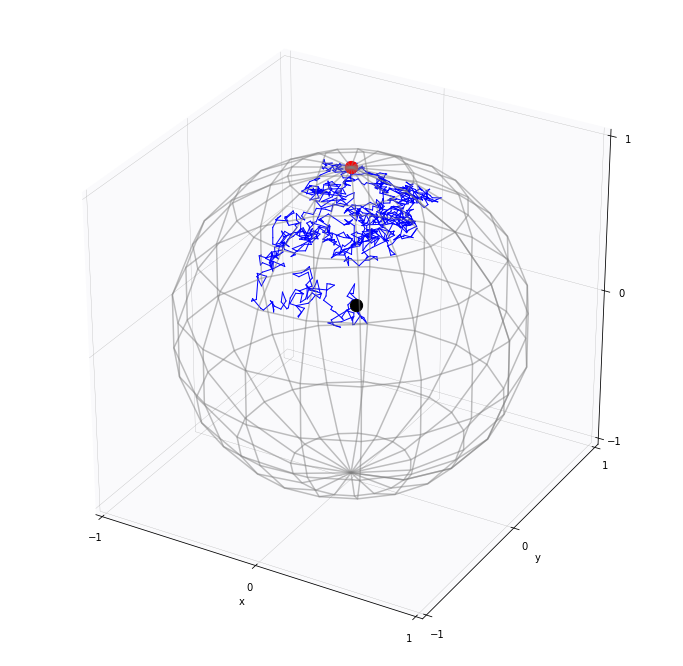

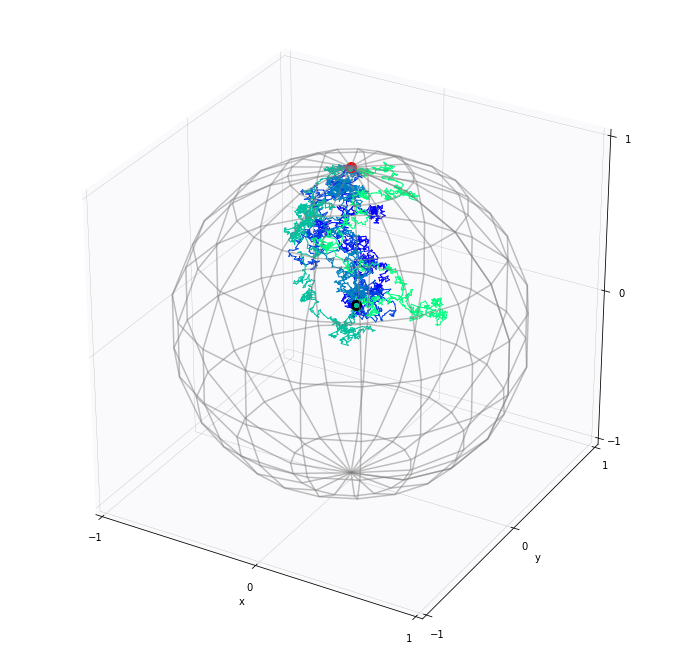

In [10]:
n_steps.set_value(1000)

x = np.array([np.pi/2,np.pi/2])

w = M.Exptf(x,tensor(np.array([.8,-.5])))[-1]
(ts,xs,log_likelihood,log_varphi) = Brownian_coords_guidedf(x,w,dWsf(M.dim.eval()))[:4]
print("log likelihood: ", log_likelihood[-1], ", log varphi: ", log_varphi[-1])

# plot
newfig()
M.plot()
M.plotx(xs)
M.plotx(x,color='r',s=150)
M.plotx(w,color='k',s=150)
plt.show()

# plot multiple bridges
N = 5
xss = np.zeros((N,n_steps.eval(),M.dim.eval()),dtype=theano.config.floatX)
for i in range(N):
    (ts,xs,log_likelihood,log_varphi) = Brownian_coords_guidedf(x,w,.4*dWsf(M.dim.eval()))[:4]
    xss[i] = xs

# plot
M.newfig()
M.plot()
colormap = plt.get_cmap('winter')
colors=[colormap(k) for k in np.linspace(0, 1, N)]
for i in range(N):
    M.plotx(xss[i],color=colors[i])
M.plotx(x,color='r',s=100)
M.plotx(w,color='k',s=100)
plt.savefig('S2_bridges.pdf')
plt.show()

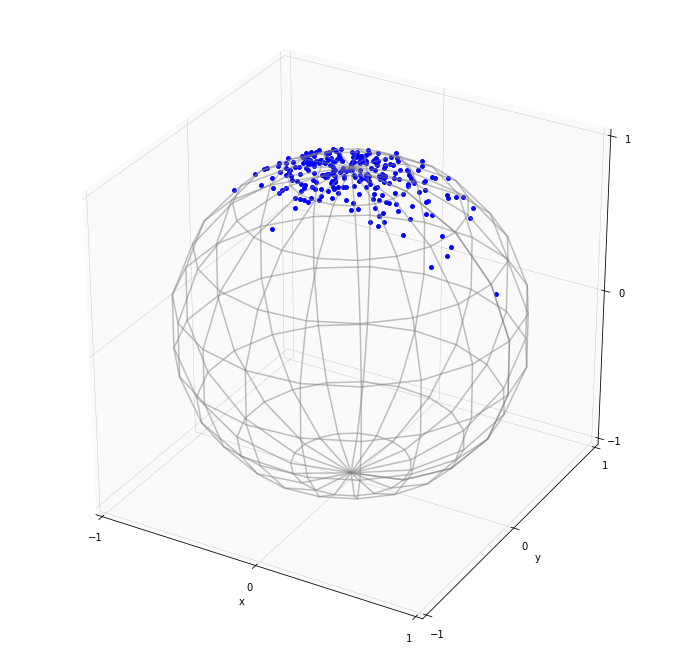

In [11]:
## Sample Data

var = .2
n_steps.set_value(1000)

N_samples = 256
x = np.array([np.pi/2,np.pi/2])

samples = np.zeros((N_samples,M.dim.eval()))
for i in range(N_samples):
    (ts,xs) = M.Brownian_coordsf(x,var*dWsf(M.dim.eval()))
    samples[i] = xs[-1]

# plot
newfig()
M.plot()
for i in range(N_samples):
    M.plotx(samples[i])
plt.show()

In [ ]:
# ML mean estimation

options = {}
options['samples_per_obs'] = 1
options['epochs'] = 50
options['learning_rate'] = .5e0
options['varphi_update_rate'] = 1.
options['initial'] = [x+.0*np.random.randn(M.dim.eval())]
options['verbose'] = True

# Transition density
# transition density etc.
q0 = M.element()
v = M.element()
thetas = (q0,)
log_p_Tf = theano.function([q0,v],log_p_T(q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords))
dlog_p_Tf = theano.function([q0,v],dlog_p_T(thetas,q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords))
p_Tf = theano.function([q0,v],T.exp(log_p_T(q0,v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords)))

v = x
print(x)
print(v)
%time print(log_p_Tf(x,v))
%time print(p_Tf(x,v))
%time print(dlog_p_Tf(x,v))

from src.statistics.mle import *

def llog_p_T(thetas,pars):
    (v,seed) = pars
    if seed:
        srng.seed(seed)
    q = thetas[0]
    ie = 0
    while True:
        try:
            return dlog_p_Tf(q,v)
        except ValueError: 
            if i >= 5:
                print(ie,v)
            ie += 1
            pass    

def update_thetas(thetas, dthetas):
    q = thetas[0]
    
    q += options['learning_rate']*np.dot(M.gsharpf(q),dthetas[0]) # use Riemannian g-gradient
    
    return (q,)

# run MLE
(thetas, log_likelihood, log_likelihoods, thetass) = iterative_mle(samples,llog_p_T,update_thetas,options)

# plot
plt.plot(range(options['epochs']),log_likelihoods)
# plt.savefig('ML_likelihoods.pdf')
plt.show()
plt.plot(range(options['epochs']),thetass[0].reshape((thetass[0].shape[0],-1)))
# plt.savefig('ML_thetas.pdf')
plt.show()

M.newfig()
M.plot()
M.plotx(thetas[0],s=150)
M.plotx(np.vstack((options['initial'][0],thetass[0])),color='blue',linewidth=2.5)
M.plotx(np.vstack((np.zeros((1,2)),iterations)),color='red',linewidth=2.5)
plt.savefig('MLmean_iterations.pdf')
plt.show()

n_steps.set_value(100)

transition density with v constant
transition density with v constant
transition density with v constant
[1.57079633 1.57079633]
[1.57079633 1.57079633]
-1.8378223825999136
CPU times: user 394 ms, sys: 4.03 ms, total: 398 ms
Wall time: 396 ms
0.15920844786863358
CPU times: user 390 ms, sys: 30 µs, total: 390 ms
Wall time: 387 ms


/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[array(-1.83774354), array([-1.78548859e-19,  3.45588022e-04])]
CPU times: user 3.63 s, sys: 12.1 ms, total: 3.64 s
Wall time: 3.64 s
initial thetas: [[1.57079633 1.57079633]]
0 [1.52980168 1.74142451]
0 [1.17185324 1.03981354]


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-12-892dd553eef7>", line 37, in llog_p_T
    return dlog_p_Tf(q,v)
  File "/home/stefan/projects/thea

# SO(3)

In [2]:
# SO(3)
from src.groups.SON import *
G = SON(3,invariance='right')
print(G)

from src.plotting import *

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanoge

SO(3) (dimension 3)


In [3]:
from src.group import invariant_metric
invariant_metric.initialize(G)

from src.group import energy
energy.initialize(G)

/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

In [4]:
q = np.array([1e-6,0,0])
g = G.psif(q)
v = np.array([0,1,1])
p = G.sharppsif(q,v)

/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

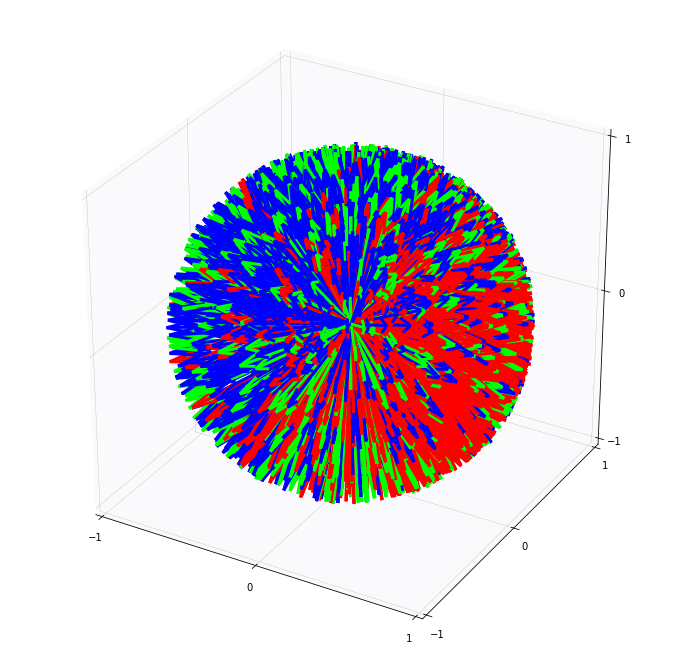

In [5]:
# sample data
from src.stochastics import Brownian_inv
Brownian_inv.initialize(G)

G.sigma.set_value(np.diag((1.,.3,1.4))) # set metric
K = 1024
obss = np.zeros((K,)+g.shape)
# srng.seed(422)
for i in range(K):
    (ts,gs) = G.Brownian_invf(g,dWsf(G.dim.eval()))
    obss[i] = gs[-1]

# plot samples
newfig()
for i in range(K):
    G.plotg(obss[i])
plt.show()

/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

log likelihood:  -1.9319142061868197 , log varphi:  -1.9319142061868197


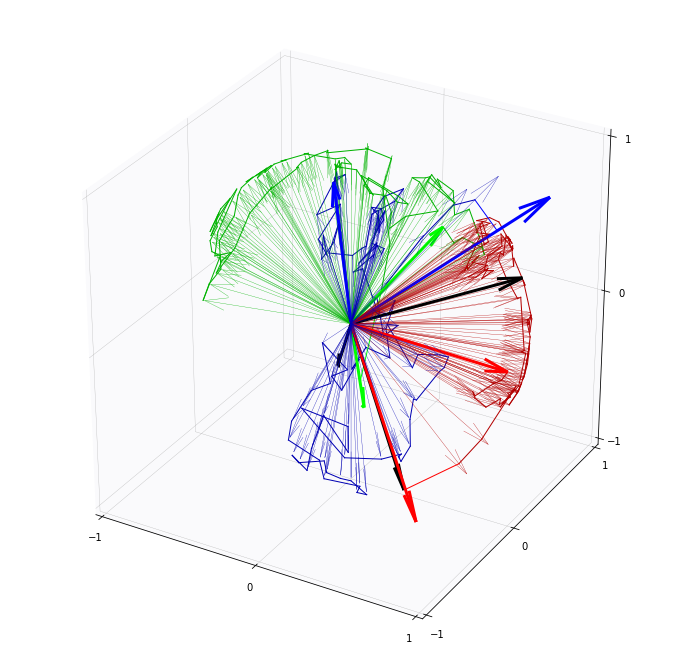

NameError: name 'M' is not defined

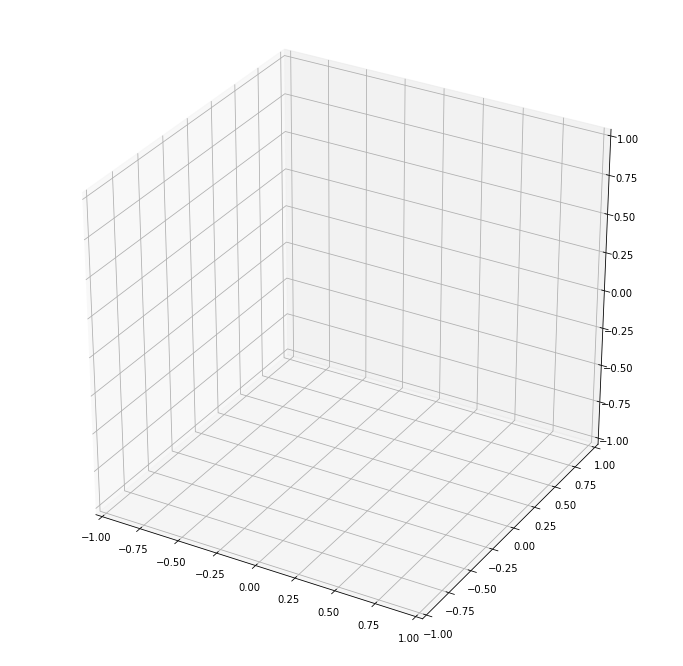

In [6]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# hit target v at time t=Tend
def get_sde_guided(sde_f, phi, sqrtCov, A=None, method='DelyonHu', integration='ito'):
    assert (integration is 'ito' or integration is 'stratonovich')
    assert (method is 'DelyonHu')  # more general schemes not implemented

    def sde_guided(dW, t, x, log_likelihood, log_varphi, v, *ys):
        (det, sto, X, *dys_sde) = sde_f(dW, t, x, *ys)
        h = theano.ifelse.ifelse(T.lt(t, Tend - dt / 2),
                                 phi(x, v) / (Tend - t),
                                 T.zeros_like(phi(x, v))
                                 )
        sto = theano.ifelse.ifelse(T.lt(t, Tend - 3 * dt / 2),  # for Ito as well?
                                   sto,
                                   T.zeros_like(sto)
                                   )

        ### likelihood
        dW_guided = (1 - .5 * dt / (1 - t)) * dW + dt * h  # for Ito as well?
        sqrtCovx = sqrtCov(x)
        Cov = dt * T.tensordot(sqrtCovx, sqrtCovx, (1, 1))
        Pres = T.nlinalg.MatrixInverse()(Cov)
        residual = T.tensordot(dW_guided, T.tensordot(Pres, dW_guided, (1, 0)), (0, 0))
        log_likelihood = .5 * (-dW.shape[0] * T.log(2 * np.pi) + LogAbsDet()(Pres) - residual)

#         ## correction factor
#         ytilde = T.tensordot(X, h * (Tend - t), 1)
#         tp1 = t + dt
#         if integration is 'ito':
#             xtp1 = x + dt * (det + T.tensordot(X, h, 1)) + sto
#         elif integration is 'stratonovich':
#             tx = x + sto
#             xtp1 = x + dt * det + 0.5 * (sto + sde_f(dW, tp1, tx, *ys)[1])
#         Xtp1 = sde_f(dW, tp1, xtp1, *ys)[2]
#         ytildetp1 = T.tensordot(Xtp1, phi(xtp1, v), 1)

#         # set default A if not specified
#         Af = A if A is not None else lambda x, v, w: T.tensordot(v, T.tensordot(T.nlinalg.MatrixInverse()(T.tensordot(X, X, (1, 1))), w, 1), 1)

#         #     add t1 term for general phi
#         #     dxbdxt = theano.gradient.Rop((Gx-x[0]).flatten(),x[0],dx[0]) # use this for general phi
#         t2 = theano.ifelse.ifelse(T.lt(t, Tend - dt / 2),
#                                   -Af(x, ytilde, dt * det) / (Tend - t),
#                                   # check det term for Stratonovich (correction likely missing)
#                                   0.)
#         t34 = theano.ifelse.ifelse(T.lt(tp1, Tend - dt / 2),
#                                    -(Af(xtp1, ytildetp1, ytildetp1) - Af(x, ytildetp1, ytildetp1)) / (
#                                    2 * (Tend - tp1 + dt * T.gt(tp1, Tend - dt / 2))),
#                                    # last term in divison is to avoid NaN with non-lazy Theano conditional evaluation
#                                    0.)
        log_varphi = log_likelihood#t2 + t34

        return (det + T.tensordot(X, h, 1), sto, X, log_likelihood, log_varphi, T.zeros_like(v), *dys_sde)

    return sde_guided

def get_guided_likelihood(M, sde_f, phi, sqrtCov, q, A=None, method='DelyonHu', integration='ito'):
    sde_guided = get_sde_guided(sde_f, phi, sqrtCov, A, method, integration)
    guided = lambda q, v, dWt: integrate_sde(sde_guided,
                                             integrator_ito if method is 'ito' else integrator_stratonovich,
                                             q, dWt, T.constant(0.), T.constant(0.), v)
    v = M.element()
    guidedf = theano.function([q, v, dWt], guided(q, v, dWt)[:4])

    return (guided, guidedf)

# parameters
g0 = G.element()
thetas = (g0, G.sigma,)
thetas_true = [g]+[theta.eval() for theta in thetas[1:]]

# guide function
phi = lambda g,v: G.LAtoV(G.invtrns(G.inv(g),v)-G.e)
# phi = lambda g,v: T.tensordot(G.inv(G.sigma),G.LAtoV(G.log(G.invtrns(G.inv(g),v))),(1,0))

# (Brownian_inv_guided,Brownian_inv_guidedf) = get_guided_likelihood(G,G.sde_Brownian_inv,phi,lambda g: G.sigma, g0, thetas, A=G.gG, integration='stratonovich')
(Brownian_inv_guided,Brownian_inv_guidedf) = get_guided_likelihood(G,G.sde_Brownian_inv,phi,lambda g: G.sigma, g0, A=G.gG, integration='stratonovich')

w = G.psif(v)
(ts,gs,log_likelihood,log_varphi) = Brownian_inv_guidedf(g,w,dWsf(G.dim.eval()))[:4]
print("log likelihood: ", log_likelihood[-1], ", log varphi: ", log_varphi[-1])

newfig()
G.plotg(gs)
G.plotg(w,color='k')
# plt.savefig('/home/stefan/Dropbox/projects/diffusion/figures/SO3-bridge.pdf')
plt.show()

In [7]:
options = {}
options['samples_per_obs'] = 20
options['epochs'] = 10
options['learning_rate'] = 6.e-3
options['varphi_update_rate'] = 1.
options['verbose'] = True
options['initial'] = [obss[0], # random value
                      np.diag((.08,.1,.2)),]
# options['update_v'] = lambda g: theano.gradient.disconnected_grad(Brownian_inv_fiber(g,dWs(G.dim))[1][-1])
# options['update_vf'] = lambda g: Brownian_inv_fiberf(g,dWsf(G.dim.eval()))[1][-1]

In [8]:
# helper for log-transition density
def p_T_log_p_T(g, v, dWs, bridge_sde, phi, options, sigma=None, sde=None):
    """ Monte Carlo approximation of log transition density from guided process """
    if sigma is None and sde is not None:
        (_, _, XT) = sde(dWs, Tend, v)  # starting point of SDE, we need diffusion field X at t=0
        sigma = XT
    assert (sigma is not None)
    
    # sample noise
    (cout, updates) = theano.scan(fn=lambda x: dWs,
                                  outputs_info=[T.zeros_like(dWs)],
                                  n_steps=options['samples_per_obs'])
    dWsi = cout

    if not 'update_v' in options:
        # v constant throughout sampling
        print("transition density with v constant")

        # bridges
        Cgv = T.sum(phi(g, v) ** 2)
        def bridge_logvarphis(dWs, log_varphi):
            (ts, gs, log_likelihood, log_varphi, _) = bridge_sde(g, v, dWs)
            return log_varphi[-1]

        (cout, updates) = theano.scan(fn=bridge_logvarphis,
                                      outputs_info=[T.constant(0.)],
                                      sequences=[dWsi])
        log_varphi = T.log(T.mean(T.exp(cout)))
        log_p_T = -.5 * sigma.shape[0] * T.log(2. * np.pi * Tend) - LogAbsDet()(sigma) - Cgv / (2. * Tend) + log_varphi
        p_T = T.exp(log_p_T)
    else:
        # update v during sampling, e.g. for fiber densities
        print("transition density with v updates")

        # bridges
        Cgv = T.sum(phi(g, v) ** 2)
        def bridge_p_T(dWs, lp_T, lv):
#             Cgv = T.sum(phi(g, lv) ** 2)
            (ts, gs, log_likelihood, log_varphi, _) = bridge_sde(g, v, dWs)            
            lp_T =  T.power(2.*np.pi*Tend,-.5*sigma.shape[0])/T.abs_(T.nlinalg.Det()(sigma))*T.exp(-Cgv/(2.*Tend))*T.exp(log_varphi[-1])
#             lv = options['update_v'](lv)                        
            return (lp_T, lv)

        (cout, updates) = theano.scan(fn=bridge_p_T,
                                      outputs_info=[T.constant(0.), v],
                                      sequences=[dWsi])
        p_T = T.mean(cout[:][0])
        log_p_T = T.log(p_T)
        v = cout[-1][1]
    
    return (p_T,log_p_T,v)

def p_T(*args,**kwargs): return p_T_log_p_T(*args,**kwargs)[0]
def log_p_T(*args,**kwargs): return p_T_log_p_T(*args,**kwargs)[1]

def dp_T(thetas,*args,**kwargs):
    """ Monte Carlo approximation of transition density gradient """
    lp_T = p_T(*args,**kwargs)
    return (lp_T,)+tuple(T.grad(lp_T,theta) for theta in thetas)

def dlog_p_T(thetas,*args,**kwargs):
    """ Monte Carlo approximation of log transition density gradient """
    llog_p_T = log_p_T(*args,**kwargs)
    return (llog_p_T,)+tuple(T.grad(llog_p_T,theta) for theta in thetas)


# Transition density
v0 = G.element()
p_Tf = theano.function([g0,v0],p_T(g0,v0,dWs(G.dim),Brownian_inv_guided,phi,options,sde=G.sde_Brownian_inv,sigma=G.sigma))
log_p_Tf = theano.function([g0,v0],log_p_T(g0,v0,dWs(G.dim),Brownian_inv_guided,phi,options,sde=G.sde_Brownian_inv,sigma=G.sigma))
dlog_p_Tf = theano.function([g0,v0],dlog_p_T(thetas,g0,v0,dWs(G.dim),Brownian_inv_guided,phi,options,sde=G.sde_Brownian_inv,sigma=G.sigma))

# G.sigma.set_value(np.diag((1.,.3,1.6))) # set metric

# # on G
print(p_Tf(g,G.psif(v))) 
print(log_p_Tf(g,G.psif(v))) 
print(dlog_p_Tf(g,G.psif(v)))

transition density with v constant


/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

transition density with v constant


/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


transition density with v constant


/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6472: UserWarning: gradient of theano.tensor.basic.ExtractDiag onlyworks for matrices.
  warnings.warn("gradient of theano.tensor.basic.ExtractDiag only"
/home/stefan/projects/theanogeometry/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different resul

0.03270983474871641
-3.8720510714764576
[array(-3.66013233), array([[-0.24073682, -0.44365371,  0.53524049],
       [-0.09358468,  0.06230835,  0.09465336],
       [-0.14371725, -0.29358521,  1.05879772]]), array([[-1.18483420e+00, -1.46535291e-01, -1.03178798e-01],
       [-3.70387642e-01,  2.81260519e+01,  6.52242799e-01],
       [-1.40052895e-02,  6.11149332e-02, -9.53317241e-01]])]


In [9]:
%%time
print(p_Tf(g,G.psif(v))) 

0.031599531010027715
CPU times: user 2.77 s, sys: 4.05 ms, total: 2.77 s
Wall time: 2.77 s


In [10]:
%%time
print(dlog_p_Tf(g,G.psif(v)))

[array(-3.80082777), array([[-0.24291228, -0.44711758,  0.47426148],
       [-0.02767945,  0.06350579,  0.12207593],
       [-0.15567103, -0.2684194 ,  1.09177227]]), array([[-1.10633419e+00, -1.83146586e-01, -6.42219510e-02],
       [-7.24194847e-02,  2.92604454e+01,  5.95691873e-01],
       [ 2.13647034e-02, -2.04825874e-03, -1.00396176e+00]])]
CPU times: user 8.66 s, sys: 15.9 ms, total: 8.68 s
Wall time: 8.67 s


In [11]:
%%time
L = options['samples_per_obs']
gsl = np.zeros((L,)+g.shape)
vl = G.psif(v)
for l in range(L):
#     (ts,gs) = Brownian_inv_fiberf(vl,dWsf(G.dim.eval()))
#     (ts,gs) = G.Brownian_invf(vl,dWsf(G.dim.eval()))
    (ts,gs,_,_) = Brownian_inv_guidedf(vl,w,dWsf(G.dim.eval()))
    gsl[l] = gs[-1]
    vl = gs[-1]

CPU times: user 2.77 s, sys: 32 ms, total: 2.8 s
Wall time: 2.79 s


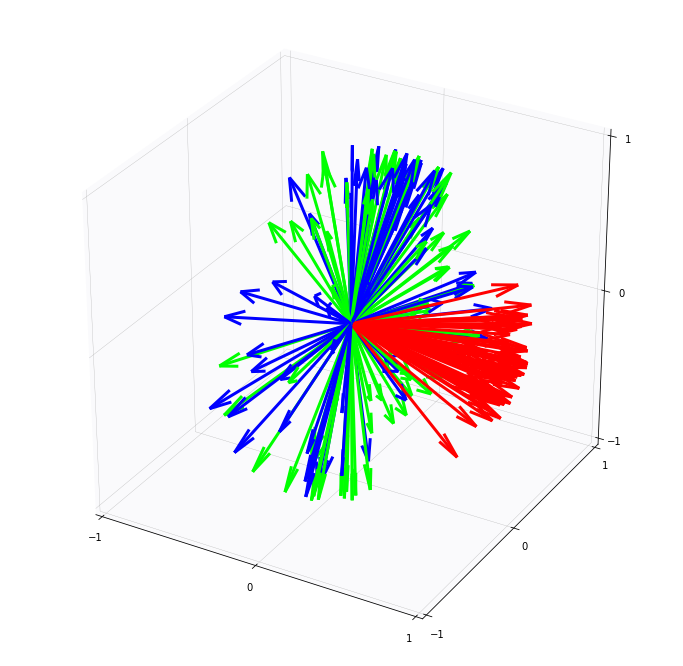

NameError: name 'M' is not defined

In [12]:
# samples for MLE
# G.sigma.set_value(1.*np.eye(G.dim.eval())) # set metric, uniform
G.sigma.set_value(np.diag((.2,.2,1.5))) # anisotropic
K = 64

obss = np.zeros((K,)+g.shape)
# srng.seed(422)
for i in range(K):
    (ts,gs) = G.Brownian_invf(g,dWsf(G.dim.eval()))
    obss[i] = gs[-1]

# plot samples
newfig()
for i in range(K):
    G.plotg(obss[i])
plt.show()

In [ ]:
# sample bridges
def lbridge_sampling(thetas,*args,**kwargs):
    g = thetas[0]
    G.sigma.set_value(thetas[1])
    return partial(bridge_sampling,g,Brownian_inv_guidedf,lambda: dWsf(G.dim.eval()),options)(*args,**kwargs)

log_phis = np.zeros((K,))
try:
    mpu.openPool()
    sol = mpu.pool.imap(partial(lbridge_sampling,options['initial']),mpu.inputArgs(obss,np.random.randint(1000,size=K)))
    res = list(sol)
    bridges = mpu.getRes(res,0)
    log_varphis = mpu.getRes(res,1)
    log_likelihoods = mpu.getRes(res,2)
except:
    mpu.closePool()
    raise
else:
    mpu.closePool()

Process ForkPoolWorker-2:
Traceback (most recent call last):


In [ ]:
%%time
# on SO(3)
from src.statistics.mle import *

def llog_p_T(thetas,pars):
    (v,seed) = pars
    if seed:
        srng.seed(seed)
    g = thetas[0]
    G.sigma.set_value(thetas[1])
    return dlog_p_Tf(g,v)

def update_thetas(thetas, dthetas):
    g = thetas[0]
    sigma = thetas[1]
    
#     g = G.to_groupf(g+options['learning_rate']*dthetas[0])
    sigma += options['learning_rate']*dthetas[1]
    
    return (g,sigma)

# run MLE
(thetas, log_likelihood, log_likelihoods, thetass) = iterative_mle(obss,llog_p_T,update_thetas,options)

# plot
plt.plot(range(options['epochs']),log_likelihoods)
plt.show()
plt.plot(range(options['epochs']),thetass[0].reshape((thetass[0].shape[0],-1)))
plt.hlines(thetas_true[0].flatten(),plt.xlim()[0],plt.xlim()[1],color='r')
plt.show()
plt.plot(range(options['epochs']),thetass[1].reshape((thetass[1].shape[0],-1)))
plt.hlines(thetas_true[1].flatten(),plt.xlim()[0],plt.xlim()[1],color='r')
plt.show()
None